In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import statistics
import pandas as pd
%matplotlib inline

In [2]:
## basic read in

In [3]:
def max_acc_point(acc_list):
    acc_point = np.argmax(acc_list)
    return acc_point

In [4]:
def min_loss_point(loss_list):
    loss_point = np.argmin(loss_list)
    return loss_point

In [5]:
def es_point(acc_list,p): # p means steps after the max index
    max_num = 0
    count = 0
    for i in range(len(acc_list)):
        if acc_list[i]>max_num:
            max_num = acc_list[i]
            count = 0
        count = count+1
        if count>p:
            return i-1
    return int(len(acc_list)-1)

In [6]:
def windowed(s,half_window): # s is a list
    s_mean=[]
    s_var=[]
    window_size = half_window*2 + 1
    for i in range(len(s)-window_size+1):
        k = i + half_window 
        s_sub=s[k-half_window:k+half_window+1]
        sub_mean=sum(s_sub)/len(s_sub)
        s_mean.append(sub_mean)
        sub_var=statistics.variance(s_sub)
        s_var.append(sub_var)
    return s_mean,s_var

In [7]:
def read_acc_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['acc'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean
def read_loss_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['loss'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean

In [8]:
## how to plot

In [9]:
def plot_line(i,k,basedir,result,lab,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=500
    s1_epo = [i+1 for i in s1[0][:p]]
    ax[i].plot(s1_epo,s1[1][:p], label=lab[k]+addon)

In [10]:
def plot_window_loss(i,k,half_window,basedir,result,lab,line_color,dot_color,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    
    (s_mean,s_varience)=windowed(s1[1][:p],half_window)

    s_epo=[i+half_window+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=lab[k]+addon,color = line_color) # can also plot s_varience if want
    
    (s_loss,_)=windowed(s1[1][:p],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    ax[i].plot(index_min_loss+half_window+1,s_mean[index_min_loss],dot_color)

#     index_max=np.argmax(s_mean)
#     ax[i].plot(index_max,s_mean[index_max],dot_color)

In [11]:
def plot_file_loss(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_loss_mean(files,i,speed)
        set_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(set_plt,normalset_mean, label=linelab+'_usual')
#         print('only usual')
        
    else:
        normalset_mean,delayset_mean = read_loss_mean(files,i,speed)
        
        normal_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(normal_plt,normalset_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        delay_plt = [i+1 for i in range(len(new_delay_set))]
        ax[i].plot(delay_plt,new_delay_set, label=linelab+'_delay')

In [12]:
def plot_file_window_loss(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_loss_mean(files,i,speed)
        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab)
    else:
        normalset_mean,delayset_mean = read_loss_mean(files,i,speed)

        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        (s_mean,s_varience)=windowed(new_delay_set,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_delay')


## Data & Size & Augument

In [13]:
basedir=os.path.join('Pilot_datasize&aug')
# os.listdir(basedir)

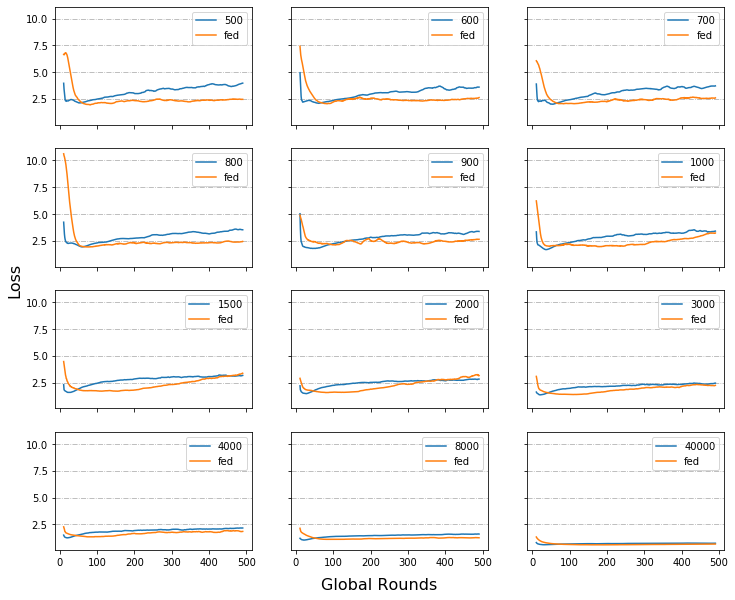

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(12, 10))

fig.text(0.5, 0.07, 'Global Rounds', ha='center',fontsize=16)
fig.text(0.07, 0.5, 'Loss', va='center', rotation='vertical',fontsize=16)
# fig.suptitle('Dataset size',fontsize=16)

result=[

    '500_central.batch50.es500.npy',
    '600_central.batch60.es500.npy',
    '700_central.batch70.es500.npy',
    '800_central.batch80.es500.npy',
    '900_central.batch90.es500.npy',
    '1000_central.batch50.es500.npy',
    '1500_central.batch50.es500.npy',
    '2000_central.batch50.es500.npy',
    '3000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '8000_central.batch50.es500.npy',
    '40000_central.batch100.es500.npy',    

    
    'iid.10w.500.loc1.earlystop500.20200518-120229.npy',
    'iid.10w.600.loc1.earlystop500.20200518-100100.npy',
    'iid.10w.700.loc1.earlystop500.20200519-063844.npy',
    'iid.10w.800.loc1.earlystop500.20200518-090515.npy',
    'iid.10w.900.loc1.earlystop500.20200518-055313.npy',
    'iid.10w.1000.loc1.earlystop500.20200518-121336.npy',
    'iid.10w.1500.loc1.earlystop500.20200518-163032.npy',
    'iid.10w.2000.loc1.earlystop500.20200518-152316.npy',
    'iid.10w.3000.loc1.earlystop500.20200519-030300.npy',
    'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
#     'iid.10w.4000_node_EVL.loc1.earlystop500.20200502-141431.npy',
    'iid.10w.8000.loc1.earlystop500.20200518-103544.npy',
    'iid.10w.40000.loc1.earlystop1000.20200521-172951.npy',

    
#     '500_central_aug.batch50.es500.npy',
#     '600_central_aug.batch60.es500.npy',
#     '700_central_aug.batch70.es500.npy',
#     '800_central_aug.batch80.es500.npy',
#     '900_central_aug.batch90.es500.npy',
#     '1000_central_aug.batch50.es500.npy',
#     '1500_central_aug.batch50.es500.npy',
#     '2000_central_aug.batch50.es500.npy',
#     '3000_central_aug.batch50.es500.npy',
#     '4000_central_aug.batch50.es500.npy',
#     '8000_central_aug.batch50.es500.npy',    
    

#     'iid.10w.500_aug.loc1.earlystop500.20200519-095444.npy',
#     'iid.10w.600_aug.loc1.earlystop500.20200519-061500.npy',
#     'iid.10w.700_aug.loc1.earlystop500.20200519-151120.npy',
#     'iid.10w.800_aug.loc1.earlystop500.20200519-113549.npy',
#     'iid.10w.900_aug.loc1.earlystop500.20200518-215743.npy',
#     'iid.10w.1000_aug.loc1.earlystop500.20200519-082723.npy',
#     'iid.10w.1500_aug.loc1.earlystop500.20200519-180855.npy',
#     'iid.10w.2000_aug.loc1.earlystop500.20200519-185445.npy',
#     'iid.10w.3000_aug.loc1.earlystop500.20200520-000150.npy',
#     'iid.10w.4000_aug.loc1.earlystop500.20200519-111208.npy',    
#     'iid.10w.8000_aug.loc1.earlystop500.20200519-170707.npy',

    
]
lab = [
    '500','600','700','800','900','1000','1500','2000','3000','4000','8000','40000',
    'fed','fed','fed','fed','fed','fed','fed','fed','fed','fed','fed','fed',
]



half_window_size=10


for j in range(4):
    for i in range(3):
        d = 3*j+i
        dd = 3*j+i+12
#         ddd = 3*j+i+24
#         dddd = 3*j+i+35
        if dd>=24:
            break
        s1=np.load(os.path.join(basedir,result[d]))    
        (s_mean,s_varience)=windowed(s1[1][:500],half_window_size)
        s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
        ax[j][i].plot(s_epo,s_mean, label=lab[d])
        
        s1=np.load(os.path.join(basedir,result[dd]))    
        (s_mean,s_varience)=windowed(s1[1][:500],half_window_size)
        s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
        ax[j][i].plot(s_epo,s_mean, label=lab[dd])
        
#         s1=np.load(os.path.join(basedir,result[ddd]))    
#         (s_mean,s_varience)=windowed(s1[1][:500],half_window_size)
#         s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
#         ax[j][i].plot(s_epo,s_mean, label=lab[ddd])        
        
#         s1=np.load(os.path.join(basedir,result[dddd]))    
#         (s_mean,s_varience)=windowed(s1[1][:500],half_window_size)
#         s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
#         ax[j][i].plot(s_epo,s_mean, label=lab[dddd])        
        
        
#         ax[j][i].set_ylim([0, 1.1])
#         ax[j][i].set_xlim([0, 1000])
        ax[j][i].grid(axis="y",ls='-.')
        ax[j][i].legend() 

## Pilot-classes

In [15]:
basedir=os.path.join('Pilot_classes')
# os.listdir(basedir)

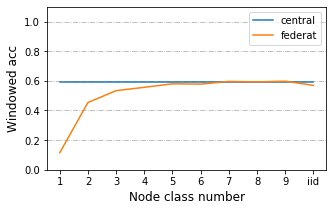

In [16]:

result=[
    
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',

    
 '1c.10w.4000.loc1.earlystop500.20200510-163959.npy',
 '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
 '3c.10w.4000.loc1.earlystop500.20200511-025044.npy',
 '4c.10w.4000.loc1.earlystop500.20200511-210547.npy',
 '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
 '6c.10w.4000.loc1.earlystop500.20200512-002851.npy',
 '7c.10w.4000.loc1.earlystop500.20200511-194406.npy',
 '8c.10w.4000.loc1.earlystop500.20200512-084500.npy',
 '9c.10w.4000.loc1.earlystop500.20200512-054621.npy',
 'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',

    
]
lab = ['central','federat']
half_window_size = 10

mean_list = []
max_list = []
point_minloss = []
max_means_list = []
for res in result:
    s1=np.load(os.path.join(basedir,res))
    (s_mean,s_varience)=windowed(s1[2][:500],half_window_size)
    (s_loss, _)=windowed(s1[1][:500],half_window_size)
    
    p = min_loss_point(s_loss)
    point_minloss.append(s_mean[p])
    
#     mean = compute_last_mean(s_mean,window=100) # mean 
#     mean_list.append(mean)
    
    s_mean.sort()    
    myMax = s_mean[-1]
    max_list.append(myMax)
    
#     max_means = largest_several_mean(s_mean,count=20,neglect=5)
#     max_means_list.append(max_means)


class_list = [1,2,3,4,5,6,7,8,9,10]
myclass = len(class_list)
for i in [0,1]:

#     plt.plot(class_list,mean_list[i*myclass:i*myclass+myclass],label = lab[i])  # mean
#     plt.plot(class_list,max_list[i*myclass:i*myclass+myclass],label = lab[i]) # max--> the max windowed acc
    plt.plot(class_list,point_minloss[i*myclass:i*myclass+myclass],label = lab[i]) # acc at min loss
#     plt.plot(class_list,max_means_list[i*myclass:i*myclass+myclass],label = lab[i]) # average of several biggest acc


    plt.gcf().set_size_inches(5, 3)
#     plt.title('Effect of non-IID',fontsize=16)
    plt.xlabel('Node class number',fontsize=12)
    plt.xticks([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,'iid'])
    plt.ylabel('Windowed acc',fontsize=12)
    plt.ylim([0, 1.1])
    plt.grid(axis="y",ls='-.')
    plt.legend()

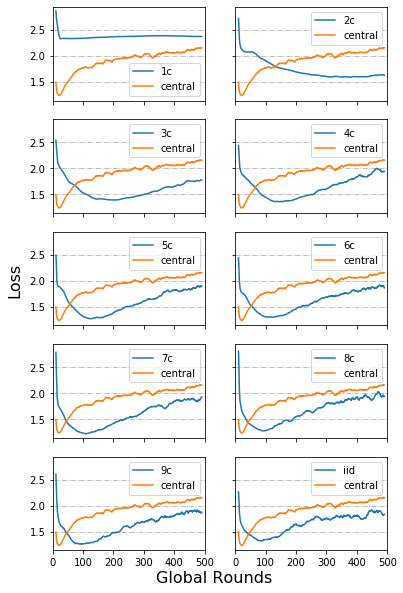

In [17]:
fig, ax = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(6, 10))

fig.text(0.5, 0.08, 'Global Rounds', ha='center',fontsize=16)
fig.text(0.02, 0.5, 'Loss', va='center', rotation='vertical',fontsize=16)

# fig.suptitle('Effect of non-IID',fontsize=16)

result=[
 '1c.10w.4000.loc1.earlystop500.20200510-163959.npy',
 '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
 '3c.10w.4000.loc1.earlystop500.20200511-025044.npy',
 '4c.10w.4000.loc1.earlystop500.20200511-210547.npy',
 '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
 '6c.10w.4000.loc1.earlystop500.20200512-002851.npy',
 '7c.10w.4000.loc1.earlystop500.20200511-194406.npy',
 '8c.10w.4000.loc1.earlystop500.20200512-084500.npy',
 '9c.10w.4000.loc1.earlystop500.20200512-054621.npy',
 'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
 '4000_central.batch50.es500.npy',
]
lab = [
    res[:-47] for res in result[:-1]
]
lab.append('central')


half_window_size=10

min_loss_index = []

for j in range(5):
    for i in range(2):
        d = 2*j+i
        s1=np.load(os.path.join(basedir,result[d]))    
        (s_mean,s_varience)=windowed(s1[1][:500],half_window_size)
        p = min_loss_point(s_mean)
        min_loss_index.append(p+half_window_size)
        s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
        ax[j][i].plot(s_epo,s_mean, label=lab[d])
        
        s1=np.load(os.path.join(basedir,result[10]))    
        (s_mean,s_varience)=windowed(s1[1][:500],half_window_size)
        s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
        ax[j][i].plot(s_epo,s_mean, label=lab[10])
        
#         ax[j][i].set_ylim([0, 1.1])
        ax[j][i].set_xlim([0, 500])
        ax[j][i].grid(axis="y",ls='-.')
        ax[j][i].legend() 


No handles with labels found to put in legend.


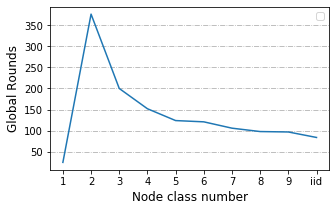

In [18]:
epo = [i+1 for i in range(len(min_loss_index))]
plt.plot(epo,min_loss_index)

plt.gcf().set_size_inches(5, 3)

plt.xlabel('Node class number',fontsize=12)
plt.xticks([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,'iid'])
plt.ylabel('Global Rounds',fontsize=12)
plt.grid(axis="y",ls='-.')
plt.legend()